In [1]:
# notebook that generates figure 1 in the extended abstract

In [2]:
import numpy as np
import pandas as pd
import argparse
import sklearn
import os
import mne
import json
import math
import time
import fooof
import matplotlib.pyplot as plt

import CanonParam._temporary_data_loading.load_open_closed_data as locd
import CanonParam._temporary_data_loading.data_utils as du
import CanonParam._temporary_data_loading.epoch_creation as ec
import CanonParam.parameterize_spectra as bandparams


# Load in the Data

In [3]:
example_spectra = np.load('../data/example_comparison_spectra.npz')
sample_freqs = example_spectra['sample_freqs']
sample_psd = example_spectra['sample_psd']
channels = example_spectra['channels']
channel = 'O2'
chdx = np.where(channels == channel)[0][0]

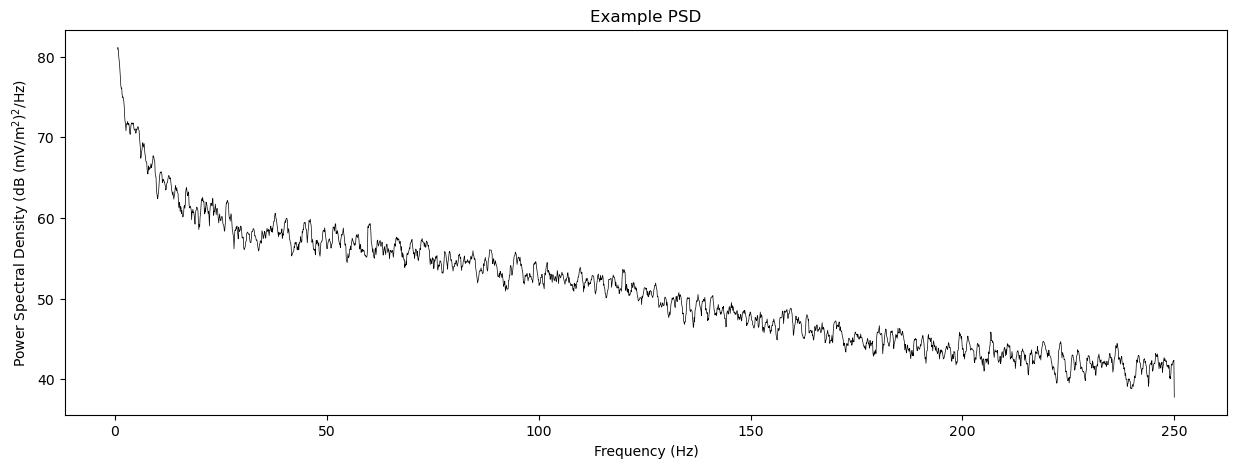

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(sample_freqs, 10*np.log10(1e6*sample_psd[chdx, :]), color='black', linewidth=.5)
plt.xlabel('Frequency (Hz)');
plt.ylabel('Power Spectral Density (dB (mV/m$^2$)$^2$/Hz)');
plt.title('Example PSD');
plt.show()


(2495,) (19, 2495)


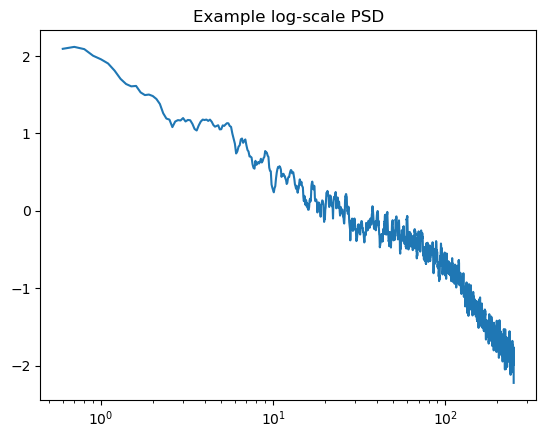

In [5]:
sample_psd = sample_psd[:, sample_freqs > 0.5]
sample_freqs = sample_freqs[sample_freqs > 0.5]
print(sample_freqs.shape, sample_psd.shape)
plt.plot(sample_freqs, np.log10(sample_psd)[chdx])
plt.title('Example log-scale PSD')
plt.xscale('log')
plt.show()

# theirs vs ours

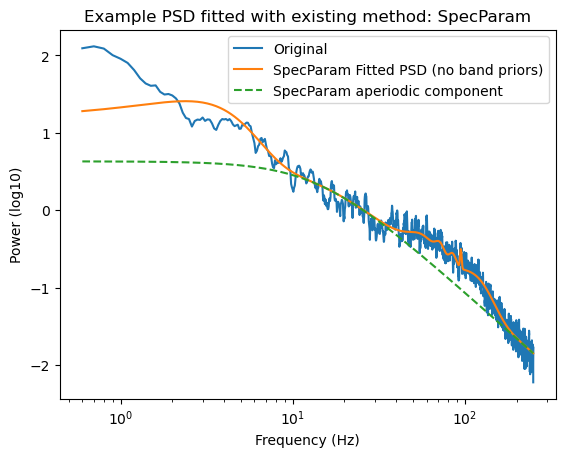

In [6]:
max_n_peaks=7
fm = fooof.FOOOF(peak_width_limits=(2.0, 100.0), max_n_peaks=max_n_peaks, min_peak_height=0.2, peak_threshold=2.0, aperiodic_mode='knee', verbose=True)
# freqs0, power0 = interpolate_notches(notches, notch_width, freqs, open_power[0,0,:])
fm.fit(freqs=sample_freqs, power_spectrum=sample_psd[chdx,:]) # taking forever when unconstrained. 
plt.plot(sample_freqs, np.log10(sample_psd[chdx,:]), label='Original')
plt.plot(sample_freqs, fm._ap_fit+fm._peak_fit, label='SpecParam Fitted PSD (no band priors)')
plt.plot(sample_freqs, fm._ap_fit, label='SpecParam aperiodic component', linestyle='--')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (log10)')
plt.xscale('log')
plt.title('Example PSD fitted with existing method: SpecParam')
plt.show()

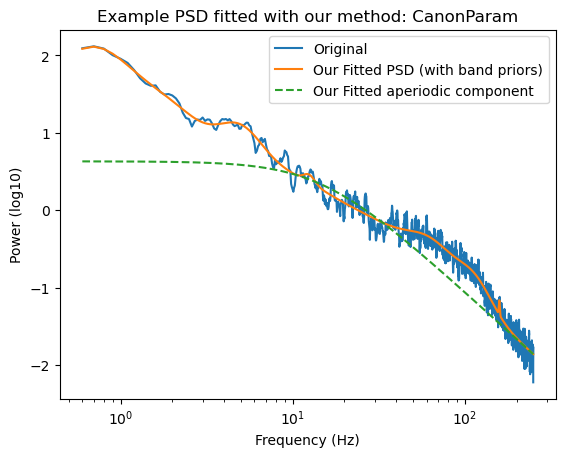

In [7]:
import importlib
importlib.reload(bandparams)
our_fitted_ps = bandparams.extract_param_spectra(sample_freqs, sample_psd[chdx,:])
our_fitted_model = our_fitted_ps.modeled_spectrum_
plt.plot(sample_freqs, np.log10(sample_psd[chdx,:]), label='Original')
plt.plot(sample_freqs, our_fitted_model, label='Our Fitted PSD (with band priors)')
plt.plot(sample_freqs, our_fitted_ps._ap_fit, label='Our Fitted aperiodic component', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (log10)')
plt.xscale('log')
plt.title('Example PSD fitted with our method: CanonParam')
plt.legend()
plt.show()  